# MNIST Auto-Encoder

## Pre-requisites

In [8]:
try:
    from cloudmesh.common.StopWatch import StopWatch
except:  # noqa: E722
    ! pip install cloudmesh-common
    from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Shell import Shell

## Import Libraries

In [9]:
StopWatch.start("total")
StopWatch.start("import")
import tensorflow as tf
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import os
import matplotlib.pyplot as plt
StopWatch.stop("import")
StopWatch.progress(0)

# cloudmesh status=running progress=0 pid=7240


In [10]:
def save(file):
    name = os.path.basename(file).replace(".py", "")
    cwd = Shell.map_filename(".").path
    Shell.mkdir(f"{cwd}/images")
    plt.savefig(f'{cwd}/images/{name}.png',dpi=300)
    plt.savefig(f'{cwd}/images/{name}.pdf')
    plt.savefig(f'{cwd}/images/{name}.svg')
    plt.show()

## Pre-Process Data

In [11]:
StopWatch.start("data-load")
(x_train, y_train), (x_test, y_test) = mnist.load_data()
StopWatch.stop("data-load")
StopWatch.progress(20)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
hidden_units = [32, 64]

# cloudmesh status=running progress=20 pid=7240


## Define Model

In [12]:
StopWatch.start("define-model")
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='images/encoder.png',
           show_shapes=True)


latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Dense(hidden_units[0], activation='relu')(x)
x = Dense(hidden_units[1], activation='relu')(x)

outputs = Dense(1, activation='relu')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='images/decoder.png', show_shapes=True)

autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='images/autoencoder.png',
           show_shapes=True)
StopWatch.start('compile')
autoencoder.compile(loss='mse', optimizer='adam')
StopWatch.stop('compile')
StopWatch.stop("define-model")
StopWatch.progress(40)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 dense_6 (Dense)             (None, 28, 28, 32)        64        
                                                                 
 dense_7 (Dense)             (None, 28, 28, 64)        2112      
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 latent_vector (Dense)       (None, 16)                802832    
                                                                 
Total params: 805,008
Trainable params: 805,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
____________________________________

## Train

In [13]:
StopWatch.start("train")
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)
StopWatch.stop("train")
StopWatch.progress(60)

1875/1875 [==============================] - 122s 65ms/step - loss: 0.0177 - val_loss: 0.0132
# cloudmesh status=running progress=60 pid=7240


## Test

In [14]:
StopWatch.start("test")
x_decoded = autoencoder.predict(x_test)
StopWatch.stop("test")
StopWatch.progress(80)

313/313 [==============================] - 7s 22ms/step
# cloudmesh status=running progress=80 pid=7240


## Visualize

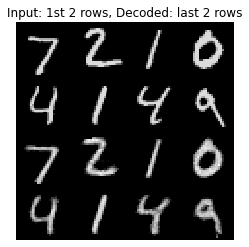

# cloudmesh status=running progress=100 pid=7240

+------------------+----------------------------------------------------------------------------------+
| Attribute        | Value                                                                            |
|------------------+----------------------------------------------------------------------------------|
| cpu              |                                                                                  |
| cpu_cores        | 4                                                                                |
| cpu_count        | 8                                                                                |
| cpu_threads      | 8                                                                                |
| date             | 2022-07-15 17:46:57.930170                                                       |
| frequency        | scpufreq(current=1298.0, min=0.0, max=1498.0)                                    |
| mem.availabl

In [15]:
StopWatch.start("visualize")
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
save('input_and_decoded.png')
StopWatch.stop("visualize")
StopWatch.stop("total")
StopWatch.progress(100)
StopWatch.benchmark()